In [1]:
import pandas as pd

# df = pd.read_csv('../data/sales.csv')
df = pd.read_csv('sales.csv')
df.dropna(subset=['price'], inplace=True)

In [2]:
df.head()

,cost,price,weight,purchase_date,product_type,product_level,maker,ingredient,height,width,depth
0,$333k,"$300,492",3 Ton 90 Kg,Dec 19 2008,"Q,B",advanced,M14122,"IN732052,IN732053",2.76 meters,97 cm,26 cm
1,NaN,"$430,570",3 Ton 30 Kg,Sep 10 1997,"J,D",basic,NaN,"IN732054,IN732055,IN732056,IN732057,IN732058",2.67 meters,98 cm,26 cm
2,$270k,"$213,070",3 Ton 40 Kg,Sep 05 2001,"J,D",basic,NaN,"IN732054,IN732059,IN732060",3.0 meters,93 cm,24 cm
3,NaN,"$229,174",3 Ton 50 Kg,Dec 23 2016,U,advanced,M14123,"IN732061,IN732062,IN732063",2.5 meters,102 cm,27 cm
4,$97k,"$122,659",2 Ton 970 Kg,Jan 12 2000,"D,R",advanced,NaN,"IN732064,IN732065,IN732066",2.47 meters,101 cm,26 cm


In [3]:
df['year'] = pd.to_datetime(df.purchase_date).dt.year
train_raw = df[df.year < 2015].reset_index(drop=True)
test_raw = df[df.year >= 2015].reset_index(drop=True)

# 1. Cost Transformation Class

**Example:** Cost Transformer. Because we need to use it with **Pipeline**, we need both X and y in the functions **fit**, **transform**, and **fit_transform**.

**bold text**![image.png](attachment:image.png)

##### <font color='red'>*</font> Cost_Transformer  
1. the input to Cost_Transformer must be a dataframe and must have a 'cost' column
2. output of the this transfomer is a dataframe with only one column 'cost'

In [4]:
class Cost_Transformer(object):
    
    def fit(self, X, y=None):
        df = pd.DataFrame()
        df['cost'] = X.cost.map(self.cost2num) # X must be a dataframe with column 'cost'
        self.mean = df.mean()
        
    def transform(self, X, y=None):
        df = pd.DataFrame()
        df['cost'] = X.cost.map(self.cost2num)
        return df.fillna(self.mean) # output of the this transfomer is a dataframe with only one column 'cost'
    
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

    def cost2num(self, x):
        if type(x) == str: 
            x = x.strip('$').strip('k')
            return float(x)*1000
        else:
            return x

In [5]:
ctf = Cost_Transformer()

In [6]:
ctf.fit_transform(train_raw).head()

,cost
0,333000.000000
1,166184.183143
2,270000.000000
3,97000.000000
4,59000.000000


In [7]:
ctf.transform(test_raw).head()

,cost
0,166184.183143
1,160000.000000
2,160000.000000
3,166184.183143
4,18000.000000


# 2. End-to-end solution

**Knowledge:** Wrapping up the feature engineering modules together with modeling modules provides an end-to-end solution to get scores from raw data.

In [8]:
features = list(train_raw.columns)
target = 'price'
features.remove(target)

In [9]:
def price2num(x):
    if type(x) == str: 
        x = x.strip('$').replace(',', '')
    return float(x)

In [10]:
X_train = train_raw[features]
y_train = train_raw[target].map(price2num)

X_test = test_raw[features]
y_test = test_raw[target].map(price2num)

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [12]:
steps = [('ctf', Cost_Transformer()),
         ('poly', PolynomialFeatures(degree = 30)),
         ('rescale', MinMaxScaler()),
         ('lr', LinearRegression())]
model = Pipeline(steps)
model = model.fit(X_train, y_train)

<font color='red'>Assignment:</font> Calculate train and test loss; visualize relationship between **cost** and **price**.

### <font color='red'>*</font> I have a question: cost data should be the raw numeric data (i.e., before fillna), right?

In [13]:
y_train_pred = model.predict(X_train)

In [14]:
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred)))

train MAE: 1.06e+05
train MSE: 2.68e+10
train R2: 0.370


In [15]:
y_test_pred = model.predict(X_test)

In [16]:
print('test MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred)))
print('test MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred)))
print('test R2: {0:.3f}'.format(r2_score(y_test, y_test_pred)))

test MAE: 1.44e+05
test MSE: 1.28e+11
test R2: -0.488


In [17]:
import matplotlib.pylab as plt
%matplotlib inline

In [29]:
import numpy as np

def plot_cost_price(cost, price, model):
    plt.scatter(cost, price, alpha=0.3)
    x = pd.DataFrame() 
    x['cost'] = np.linspace(0, 1e6) # x is a dataframe with column 'cost'
    y = model.predict(x)
    plt.plot(x.cost, y, color='r')
    plt.xlabel('cost')
    plt.ylabel('price')
    plt.xlim([0,1e6])
    plt.ylim([0,2e6])
    plt.show()

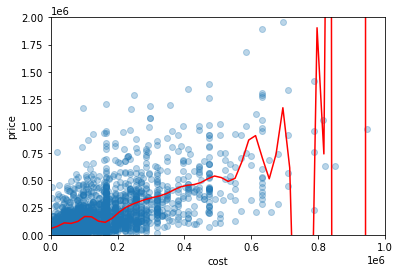

In [30]:
plot_cost_price(model.steps[0][1].fit_transform(X_train).cost, y_train, model)

### Note: This plot is probably the definition of overfitting LOL.

# 2. Lasso

<font color='red'>Assignment:</font> Use **Lasso** instead of **LinearRegression** in **Pipeline** and redo the above steps. Tune **alpha** in **Lasso**, and find the answers to following questions.

In [32]:
from sklearn.linear_model import Lasso

##### <font color='red'>*</font> ConvergenceWarning
1. increase max_iter
2. increase tol (not suggested)

In [33]:
# hide warning message
import warnings
warnings.filterwarnings("once")

steps_l = [('ctf', Cost_Transformer()),
         ('poly', PolynomialFeatures(degree = 30)),
         ('rescale', MinMaxScaler()),
#          ('lasso', Lasso(alpha = 0.5))]
#          ('lasso', Lasso(alpha = 0.5, max_iter=100000))]
         ('lasso', Lasso(alpha = 0))]


model_l = Pipeline(steps_l)
model_l = model_l.fit(X_train, y_train)

C:\Users\zhuy\Anaconda3\lib\site-packages\sklearn\pipeline.py:394: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\zhuy\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\zhuy\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.877e+13, tolerance: 1.175e+10 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.ene

In [34]:
y_train_pred_l = model_l.predict(X_train)

In [35]:
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred_l)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred_l)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred_l)))

train MAE: 1.10e+05
train MSE: 2.81e+10
train R2: 0.340


In [36]:
y_test_pred_l = model_l.predict(X_test)

In [37]:
print('test MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred_l)))
print('test MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred_l)))
print('test R2: {0:.3f}'.format(r2_score(y_test, y_test_pred_l)))

test MAE: 1.35e+05
test MSE: 5.32e+10
test R2: 0.383


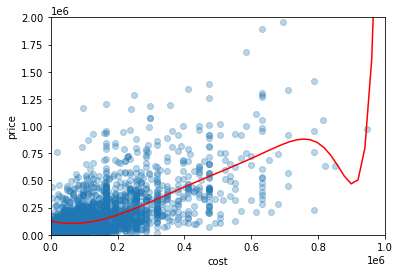

In [38]:
plot_cost_price(model_l.steps[0][1].fit_transform(X_train).cost, y_train, model_l)

### <font color='red'>*</font> I have a question: Why does the fitting using Lasso without regularization (alpha = 0) look so different from that using linear regression? I thought Lasso without regularization is similar to linear regression?

### * Not converging

<font color='red'>Question:</font> **Alpha** is a hyper parameter. What is hyper parameter? How is it different from parameter?

### A model hyperparameter is a configuration that is external to the model and whose value cannot be estimated from data, while a model parameter is a configuration variable that is internal to the model and whose value can be estimated from data.

<font color='red'>Question:</font> How does **alpha** affect the train/test loss and variance/bias?

In [ ]:
def steps(alpha):
    steps_alpha = [('ctf', Cost_Transformer()),
         ('poly', PolynomialFeatures(degree = 30)),
         ('rescale', MinMaxScaler()),
         ('lasso', Lasso(alpha = alpha))]
    model_alpha = Pipeline(steps_alpha)
    model_alpha = model_alpha.fit(X_train, y_train)
    return model_alpha

In [ ]:
alpha_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]            

In [ ]:
MAE_train = []
MAE_test = []
for alpha in alpha_list:
    model_alpha = steps(alpha)
    y_train_pred_alpha = model_alpha.predict(X_train)
    MAE_train.append(mean_absolute_error(y_train, y_train_pred_alpha))
    y_test_pred_alpha = model_alpha.predict(X_test)
    MAE_test.append(mean_absolute_error(y_test, y_test_pred_alpha))

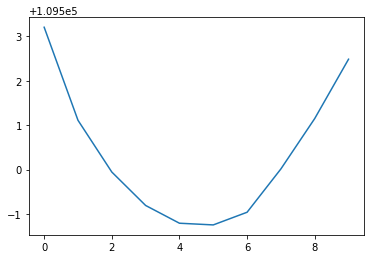

In [ ]:
plt.plot(MAE_train)

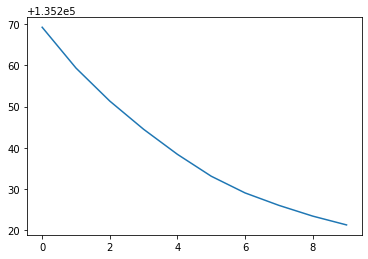

In [ ]:
plt.plot(MAE_test)

### Since the degree of the polynomial is 30, we have quite high variance and low bias. The goal of regularization is to lower the variance but as a consequence, bias will rise. As alpha increases, the training error decreases at first then increase after certain point. This happens when alpha gets big and the regularization term dominates the fitting. However, the test error keeps decreasing as designed, since our ultimate goal is to decrease the test error when predicting future price.

### <font color='red'>*</font> the MAE - alpha relationship is always not linear, thus we need to do hyperparamter tunning (train data) to find the best alpha

<font color='red'>Question:</font> How dose **alpha** affect the relationship between **price** and **cost**? How does **alpha** affect model complexity?

### Increasing alpha will smooth the relation bwteen price and cost (reduing bumps and peaks in the curve).

### Alpha has reduced the model complexity as we can see from the smooth Lasso curve.  

<font color='red'>Question:</font> How does **alpha** affect the coefficient values?

### Larger alpha, more shrinkage on the coefficient

### As we increase the value of alpha, more and more coefficients should become 0. This is why the model complexity has decreased and the curve becomes smooth. In fact, Lasso not only helps in reducing overfitting but it can help us in feature selection.

### L1 regularization can be used for feature selection

# 2. Ridge

<font color='red'>Assignment:</font> Try **Ridge** instead of **Lasso**.

In [ ]:
from sklearn.linear_model import Ridge

In [ ]:
steps_r = [('ctf', Cost_Transformer()),
         ('poly', PolynomialFeatures(degree = 30)),
         ('rescale', MinMaxScaler()),
         ('ridge', Ridge(alpha = 0.5))]
model_r = Pipeline(steps_r)
model_r = model_r.fit(X_train, y_train)

### <font color='red'>Q:</font> why we always rescale before regularization?

In [ ]:
y_train_pred_r = model_r.predict(X_train)

In [ ]:
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred_r)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred_r)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred_r)))

train MAE: 1.11e+05
train MSE: 2.85e+10
train R2: 0.331


In [ ]:
y_test_pred_r = model_r.predict(X_test)

In [ ]:
print('test MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred_r)))
print('test MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred_r)))
print('test R2: {0:.3f}'.format(r2_score(y_test, y_test_pred_r)))

test MAE: 1.36e+05
test MSE: 5.31e+10
test R2: 0.384


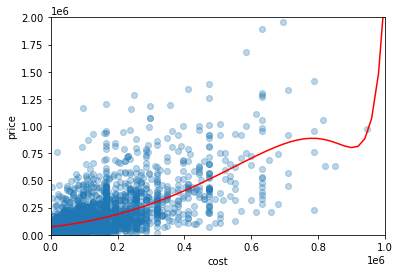

In [ ]:
plot_cost_price(model_r.steps[0][1].fit_transform(X_train).cost, y_train, model_r)

<font color='red'>Question:</font> What is regularization?

### Regularization is a technique used in Statistics to solve overfitting problems. It is also widely used in optimization to solve inverse problems. 

<font color='red'>Question:</font> How does regularization work?

### Add penalty terms to constrain the coefficient

### Regularization adds more information to the original model fitting by a penalty term. The level of renalty is controled by the parameter alpha. Depends on the application, there are different choices of penalty terms to be added to the objective function.

<font color='red'>Question:</font> What are "L1" and "L2" regularizations, respectively? How do they relate to **Ridge** and **Lasso**?

### L1 regularization, adds the L1 norm term $\alpha ||w||_{1}$ to the objective function, which is known as Lasso in Stats. L2 regularization, adds the L2 norm term $\alpha ||w||_{2}$ to the objective function, which is known as Ridge in Stats and Tikhonov regularization in optimization.

<font color='red'>Question:</font> What are the differeces between "L1" and "L2"? Why the difference between their effects on coefficient values?

### L1 introduces sparsity to the solution. By reducing some coefficients to zero, it enables feature selection. L1 is robust to outliers. L1 regularization generates simple and easy to interprete models however, L1 cannot learn complex patterns.
### L2 does not provide sparse solutions, it cannot reduce coefficients to zero, therefore no feature selection. L2 is not robust to outliers because the square effect will make outliers even more different. L2 gives a better prediction when the variables are on similar levels. L2 regularization is able to learn complex patterns.

### Difference between L1 and L2
https://medium.datadriveninvestor.com/l1-l2-regularization-7f1b4fe948f2

![image.png](attachment:image.png)

![image.png](attachment:image.png)

### From Lin's homework
![image.png](attachment:image.png)

* Visualization
1. https://explained.ai/regularization/L1vsL2.html
2. https://towardsdatascience.com/regularization-in-machine-learning-76441ddcf99a

![image.png](attachment:image.png)

* Math https://stats.stackexchange.com/questions/74542/why-does-the-lasso-provide-variable-selection

### <font color='red'>*</font> I have a question: why does L2 work better when you have collinear/codependent features?


### L1 tends to randomly select one feature, while L2 takes use of all features with even weight